In [1]:
# -------------- PART 0: PYTHON PRELIM --------------

# Additional notes: 
# mosa.py evolve() function has been edited to return final stopping temperature

# Import packages
import importlib
import os
import time
from tqdm import tqdm
import itertools
import numpy as np
import json
import mosa
import matplotlib.pyplot as plt
import pyvista as pv
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
from numpy import random
import pandas as pd

In [2]:
# -------------- PART 0: CHOOSE CIRCUIT AND SET UP FOLDER --------------


# Choose circuit
circuit = "ToyModel"

# Import circuit config file
config = importlib.import_module(circuit)

# Define the subfolder name
folder_name = f"MOSA_{circuit}"

# Create folder if not yet exist
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# Jump to folder
os.chdir(folder_name)

# Prompt new folder name
print(f"Current working directory: {os.getcwd()}")

Current working directory: /Users/nt625/Documents/GitHub/My5thMOSArepository_plsdontcrash/Metabolic_ToyModel/MOSA_ToyModel


In [3]:
# -------------- PART 0b: DEFINE DYNAMICAL SYSTEM --------------

# Import ODEs
Equ1 = config.Equ1
Equ2 = config.Equ2
Equ3 = config.Equ3
Equ4 = config.Equ4
    
# Define function to evaluate vector field
def Equs(P, t, params):
    x0 = P[0]
    x1 = P[1]
    e1 = P[2]
    e2 = P[3]
    k1 = params[0]
    k2 = params[1]
    theta1 = params[2]
    theta2 = params[3]
    val0 = Equ1(x0, e1)
    val1 = Equ2(x0, x1, e1, e2)
    val2 = Equ3(x1, e1, k1, theta1)
    val3 = Equ4(x1, e2, k2, theta2)
    return np.array([val0, val1, val2, val3])

# Define initial time
t = 0.0

In [4]:
# -------------- PART 0c: DEFINE SENSITIVITY FUNCTIONS --------------


# Define analytical sensitivity expressions
S_k1_x1_analytic = config.S_k1_x1_analytic
S_k2_x1_analytic = config.S_k2_x1_analytic

In [5]:
# -------------- PART 0d: CHOOSE SENSITIVITY FUNCTIONS --------------


# Print prompt
print("""
We have the following sensitivity functions:
0. |S_k1_x1|
1. |S_k2_x1|
2. |S_theta1_x1|
3. |S_theta2_x1|

Only 0 and 1 are available now.
""")

# Choose pair of functions
choice1 = int(input("Please select first option number:"))
choice2 = int(input("Please select second option number:"))

# List of sensitivity function names
sensitivity_labels = [
    "|S_k1_x1|",
    "|S_k2_x1|",
    "|S_theta1_x1|",
    "|S_theta2_x1|"]

# Save function names for later use
label1 = sensitivity_labels[choice1]
label2 = sensitivity_labels[choice2]

# Name for text file to records stats
output_file = f"Metabolic1_{choice1}_and_{choice2}.csv"


We have the following sensitivity functions:
0. |S_k1_x1|
1. |S_k2_x1|
2. |S_theta1_x1|
3. |S_theta2_x1|

Only 0 and 1 are available now.



In [6]:
# -------------- PART 0e: CHANGING DIRECTORIES --------------


# Define the subfolder name
subfolder_name = f"MOSA_sensfuncs_{choice1}_and_{choice2}"

# Create folder if not yet exist
if not os.path.exists(subfolder_name):
    os.makedirs(subfolder_name)

# Jump to folder
os.chdir(subfolder_name)

# Prompt new folder name
print(f"Current working directory: {os.getcwd()}")

if not os.path.exists('data'):
    os.makedirs('data')


Current working directory: /Users/nt625/Documents/GitHub/My5thMOSArepository_plsdontcrash/Metabolic_ToyModel/MOSA_ToyModel/MOSA_sensfuncs_0_and_1


In [14]:
# -------------- PART 0f: DEFINE FUNCTIONS --------------


# DEFINE FUNCTION THAT SOLVES FOR STEADY STATE OBSERVABLES TO BE MINIMISED BY MOSA

def ssfinder(k1_val, k2_val, theta1_val, theta2_val):
    # Define initial guesses (assumes a config function exists that gives them)
    InitGuesses = config.generate_initial_guesses()
    
    # Define parameter array
    params = np.array([k1_val, k2_val, theta1_val, theta2_val])
    
    # Loop through all guesses
    for InitGuess in InitGuesses:
        # Solve for steady state
        output, infodict, intflag, ier = fsolve(Equs, InitGuess, args=(0, params), xtol=1e-12, full_output=True)

        # print("fsolve output: ", output)
        # print("infodict: ", infodict)
        # print("intflag: ", intflag)
        # print("ier: ", ier)
        
        x0ss, x1ss, e1ss, e2ss = output
        fvec = infodict['fvec'] #divergence
        
        # Check Jacobian for stability
        delta = 1e-8
        J = np.zeros((4, 4))
        for i in range(4):
            dP = np.zeros(4)
            dP[i] = delta
            J[:, i] = (Equs(output + dP, 0, params) - Equs(output, 0, params)) / delta
        
        eigvals = np.linalg.eigvals(J)
        unstable = np.any(np.real(eigvals) >= 0)
        
        # Check if steady state is valid
        if np.all(output >= 0) and np.linalg.norm(fvec) < 1e-10 and intflag == 1 and not unstable:
            return x0ss, x1ss, e1ss, e2ss

    # Return NaNs if no valid steady state is found
    return float('nan'), float('nan'), float('nan'), float('nan')
    
        
# DEFINE FUNCTION THAT RETURNS PAIR OF SENSITIVITIES
def senpair(x0ss_val, x1ss_val, e1ss_val, e2ss_val, k1_val, k2_val, theta1_val, theta2_val, choice1, choice2):
    
    # Evaluate sensitivities
    S_k1_x1 = S_k1_x1_analytic(x0ss_val, x1ss_val, e1ss_val, e2ss_val, k1_val, k2_val, theta1_val, theta2_val)
    S_k2_x1 = S_k2_x1_analytic(x0ss_val, x1ss_val, e1ss_val, e2ss_val, k1_val, k2_val, theta1_val, theta2_val)

    # Sensitivity dictionary
    sensitivities = {
        "S_k1_x1": S_k1_x1,
        "S_k2_x1": S_k2_x1}

    # Map indices to keys
    labels = {
        0: "S_k1_x1",
        1: "S_k2_x1"}

    # Return values of the two sensitivities of interest
    return sensitivities[labels[choice1]], sensitivities[labels[choice2]]

# DEFINE OBJECTIVE FUNCTION TO ANNEAL
def fobj(solution):
	
	# Update parameter set
    k1_val = solution["k1"]
    k2_val = solution["k2"]
    theta1_val = solution["theta1"]
    theta2_val = solution["theta2"]
    
    print("params")
    print([k1_val, k2_val, theta1_val, theta2_val])

    # Find steady states and store.
    x0ss_val, x1ss_val, e1ss_val, e2ss_val = ssfinder(k1_val, k2_val, theta1_val, theta2_val)
    if np.isnan(x0ss_val) or np.isnan(x1ss_val) or np.isnan(e1ss_val) or np.isnan(e2ss_val):
        return np.inf, np.inf, np.inf
    
    # Get sensitivity pair
    sens1, sens2 = senpair(x0ss_val, x1ss_val, e1ss_val, e2ss_val, k1_val, k2_val, theta1_val, theta2_val, choice1, choice2)
    ans1 = float(sens1)
    ans2 = float(sens2)
    
    
    #-------------------- J -----------------------

    # Constants
    V_in = 1
    k_cat = 12
    k_m = 10
    
    # Known steady state 
    steady_state = np.array([x0ss_val, x1ss_val, e1ss_val, e2ss_val])
    
    # Tolerance for closeness to steady state
    tol = 1e-4
    
    # Event function to stop integration
    def steady_state_event(t, y, params):
        diff = y - steady_state
        if np.linalg.norm(diff) <= tol:
            return 0
        return 1
    
    steady_state_event.terminal = True  # stop the integration
    steady_state_event.direction = -1   # only trigger when getting close
    
    # Initial conditions
    y0 = [2290,0,0,0]
    params = [k1_val, k2_val, theta1_val, theta2_val]
    t_max = 5e4 
    t_eval = np.linspace(0, t_max, 10000)
    
    # Run the integration
    sol = solve_ivp(lambda t, y: Equs(y, t, params),
                    t_span=[0, t_max], 
                    y0=y0,
                    events=lambda t, y: steady_state_event(t, y, params),
                    t_eval=t_eval,
                    rtol=1e-8, 
                    atol=1e-10)
    
    print("solve_ivp: ", sol)
                    
    # Truncate solution at steady state time (if event was triggered)
    if sol.t_events[0].size > 0:
        T = sol.t_events[0][0] # time when steady state is reached
        idx_T = np.searchsorted(sol.t, T)
        t_used = sol.t[:idx_T + 1]
        x1_vals = sol.y[1, :idx_T + 1]
        e2_vals = sol.y[3, :idx_T + 1]
    else:
        print("Warning: Steady state not reached.")
        t_used = sol.t
        x1_vals = sol.y[1]
        e2_vals = sol.y[3]

    # Compute integrand at each time point
    integrand_vals = np.abs(V_in - e2_vals * (k_cat * x1_vals) / (k_m + x1_vals))
    
    # Compute the integral numerically using trap rule
    integral_val = np.trapz(integrand_vals, t_used)
    
    print(f"Integral up to steady state: {integral_val:.6f}")             
                    
    # Extract time when steady state was reached
    if sol.t_events[0].size > 0:
        time_to_ss = sol.t_events[0][0]
        print(f"Time to reach steady state: {time_to_ss:.4f}")
    else:
        print("Steady state not reached within time window.")    
    
    #-------------------------------------------
    
    
    # Check for NaN values before returning
    if np.isnan(ans1) or np.isnan(ans2):
        return np.inf, np.inf, np.inf
    return ans1, ans2, integral_val


In [15]:
# Sample rS1 values
k1_min = 0.0000001
k1_max = 0.001
k1_sampsize = 3
k1_samps = np.linspace(k1_min, k1_max, k1_sampsize)

# Sample kS1 values
k2_min = 0.0000001
k2_max = 0.001
k2_sampsize = 3
k2_samps = np.linspace(k2_min, k2_max, k2_sampsize)

# Sample kS2 values
theta1_min = 0.001
theta1_max = 10
theta1_sampsize = 3
theta1_samps = np.linspace(theta1_min, theta1_max, theta1_sampsize)

# Sample kP values
theta2_min = 0.001
theta2_max = 10
theta2_sampsize = 3
theta2_samps = np.linspace(theta2_min, theta2_max, theta2_sampsize)

In [16]:
# Create empty arrays to store ...
# ... steady states
x0ss_samps = np.array([])
x1ss_samps = np.array([])
# ... sensitivities
sens1_samps = np.array([])
sens2_samps = np.array([])

In [17]:
# WITH LOADING BAR 
# Compute the total number of iterations for tqdm
total_iterations = k1_sampsize * k2_sampsize * theta1_sampsize * theta2_sampsize
# Loop over every combination of parameters with a progress bar
for i, j, k, l in tqdm(itertools.product(k1_samps, k2_samps, theta1_samps, theta2_samps), total=total_iterations, desc="Gauging energies:"):
    
    print([i, j, k, l])

    # Get steady states and store
    x0ss, x1ss, e1ss, e2ss = ssfinder(i, j, k, l)
    
    x0ss_samps = np.append(x0ss_samps, x0ss)
    x1ss_samps = np.append(x1ss_samps, x1ss)

    # Get sensitivities and store
    sens1, sens2 = senpair(x0ss, x1ss, e1ss, e2ss, i, j, k, l, choice1, choice2)
    sens1_samps = np.append(sens1_samps, sens1)
    sens2_samps = np.append(sens2_samps, sens2)

# Get min and max of each sensitivity and print
sens1_samps_min = np.nanmin(sens1_samps)
sens2_samps_min = np.nanmin(sens2_samps)
sens1_samps_max = np.nanmax(sens1_samps)
sens2_samps_max = np.nanmax(sens2_samps)

Gauging energies::  25%|██▍       | 20/81 [00:00<00:00, 95.08it/s]

[1e-07, 1e-07, 0.001, 0.001]
[1e-07, 1e-07, 0.001, 5.000500000000001]
[1e-07, 1e-07, 0.001, 10.0]
[1e-07, 1e-07, 5.000500000000001, 0.001]
[1e-07, 1e-07, 5.000500000000001, 5.000500000000001]
[1e-07, 1e-07, 5.000500000000001, 10.0]
[1e-07, 1e-07, 10.0, 0.001]
[1e-07, 1e-07, 10.0, 5.000500000000001]
[1e-07, 1e-07, 10.0, 10.0]
[1e-07, 0.0005000499999999999, 0.001, 0.001]
[1e-07, 0.0005000499999999999, 0.001, 5.000500000000001]
[1e-07, 0.0005000499999999999, 0.001, 10.0]
[1e-07, 0.0005000499999999999, 5.000500000000001, 0.001]
[1e-07, 0.0005000499999999999, 5.000500000000001, 5.000500000000001]
[1e-07, 0.0005000499999999999, 5.000500000000001, 10.0]
[1e-07, 0.0005000499999999999, 10.0, 0.001]
[1e-07, 0.0005000499999999999, 10.0, 5.000500000000001]
[1e-07, 0.0005000499999999999, 10.0, 10.0]
[1e-07, 0.001, 0.001, 0.001]
[1e-07, 0.001, 0.001, 5.000500000000001]
[1e-07, 0.001, 0.001, 10.0]
[1e-07, 0.001, 5.000500000000001, 0.001]
[1e-07, 0.001, 5.000500000000001, 5.000500000000001]
[1e-07, 0.

Gauging energies::  64%|██████▍   | 52/81 [00:00<00:00, 54.27it/s] 

[0.0005000499999999999, 1e-07, 5.000500000000001, 10.0]
[0.0005000499999999999, 1e-07, 10.0, 0.001]
[0.0005000499999999999, 1e-07, 10.0, 5.000500000000001]
[0.0005000499999999999, 1e-07, 10.0, 10.0]
[0.0005000499999999999, 0.0005000499999999999, 0.001, 0.001]
[0.0005000499999999999, 0.0005000499999999999, 0.001, 5.000500000000001]
[0.0005000499999999999, 0.0005000499999999999, 0.001, 10.0]
[0.0005000499999999999, 0.0005000499999999999, 5.000500000000001, 0.001]
[0.0005000499999999999, 0.0005000499999999999, 5.000500000000001, 5.000500000000001]
[0.0005000499999999999, 0.0005000499999999999, 5.000500000000001, 10.0]
[0.0005000499999999999, 0.0005000499999999999, 10.0, 0.001]
[0.0005000499999999999, 0.0005000499999999999, 10.0, 5.000500000000001]
[0.0005000499999999999, 0.0005000499999999999, 10.0, 10.0]
[0.0005000499999999999, 0.001, 0.001, 0.001]
[0.0005000499999999999, 0.001, 0.001, 5.000500000000001]
[0.0005000499999999999, 0.001, 0.001, 10.0]
[0.0005000499999999999, 0.001, 5.0005000

Gauging energies::  91%|█████████▏| 74/81 [00:01<00:00, 47.69it/s]

[0.0005000499999999999, 0.001, 10.0, 5.000500000000001]
[0.0005000499999999999, 0.001, 10.0, 10.0]
[0.001, 1e-07, 0.001, 0.001]
[0.001, 1e-07, 0.001, 5.000500000000001]
[0.001, 1e-07, 0.001, 10.0]
[0.001, 1e-07, 5.000500000000001, 0.001]
[0.001, 1e-07, 5.000500000000001, 5.000500000000001]
[0.001, 1e-07, 5.000500000000001, 10.0]
[0.001, 1e-07, 10.0, 0.001]
[0.001, 1e-07, 10.0, 5.000500000000001]
[0.001, 1e-07, 10.0, 10.0]
[0.001, 0.0005000499999999999, 0.001, 0.001]
[0.001, 0.0005000499999999999, 0.001, 5.000500000000001]
[0.001, 0.0005000499999999999, 0.001, 10.0]
[0.001, 0.0005000499999999999, 5.000500000000001, 0.001]
[0.001, 0.0005000499999999999, 5.000500000000001, 5.000500000000001]
[0.001, 0.0005000499999999999, 5.000500000000001, 10.0]
[0.001, 0.0005000499999999999, 10.0, 0.001]
[0.001, 0.0005000499999999999, 10.0, 5.000500000000001]
[0.001, 0.0005000499999999999, 10.0, 10.0]
[0.001, 0.001, 0.001, 0.001]
[0.001, 0.001, 0.001, 5.000500000000001]


Gauging energies:: 100%|██████████| 81/81 [00:01<00:00, 57.81it/s]


[0.001, 0.001, 0.001, 10.0]
[0.001, 0.001, 5.000500000000001, 0.001]
[0.001, 0.001, 5.000500000000001, 5.000500000000001]
[0.001, 0.001, 5.000500000000001, 10.0]
[0.001, 0.001, 10.0, 0.001]
[0.001, 0.001, 10.0, 5.000500000000001]
[0.001, 0.001, 10.0, 10.0]


In [18]:
x0ss_samps

array([2.29031113e+03, 2.29026041e+03, 2.29026040e+03, 2.28199178e+03,
       2.27905186e+03, 2.27607160e+03, 2.27790376e+03, 2.27632534e+03,
       2.27292972e+03, 2.28391600e+03, 2.27435812e+03, 2.27435812e+03,
       2.28199116e+03, 2.25844667e+03, 2.25844667e+03, 2.27790345e+03,
       2.25844666e+03, 2.25844666e+03, 2.27432425e+03, 2.26854134e+03,
       2.26854134e+03, 2.28199054e+03, 2.25844666e+03, 2.25844666e+03,
       2.27790314e+03, 2.25844666e+03, 2.25844666e+03, 2.28980243e+03,
       2.28895823e+03, 2.28895580e+03, 2.13246160e+03, 2.13244172e+03,
       2.13238230e+03, 2.03987133e+03, 2.03986326e+03, 2.03983910e+03,
       2.28978327e+03, 1.94681866e+03, 1.94681549e+03, 2.13246160e+03,
       3.27646574e-01, 3.27637167e-01, 2.03987133e+03, 3.26581331e-01,
       3.26578978e-01, 2.28976306e+03, 1.74565401e+03, 1.74565086e+03,
       2.13246160e+03, 3.26567732e-01, 3.26567195e-01, 2.03987133e+03,
       3.26311542e-01, 3.26311407e-01, 2.28966200e+03, 2.28860834e+03,
      

In [19]:
x1ss_samps

array([3.17288148e-02, 1.96522041e-02, 1.96521461e-02, 8.39700425e+00,
       6.75565165e+00, 5.55747173e+00, 1.25076570e+01, 1.12944030e+01,
       9.12058453e+00, 1.99086504e-03, 9.97776502e-04, 9.97776487e-04,
       8.39658321e+00, 1.99125712e-03, 1.99125688e-03, 1.25073993e+01,
       1.99125736e-03, 1.99125712e-03, 9.95659917e-04, 6.80509200e-04,
       6.80509194e-04, 8.39616213e+00, 9.95659915e-04, 9.95659885e-04,
       1.25071416e+01, 9.95659945e-04, 9.95659915e-04, 5.43326047e-01,
       3.39426928e-01, 3.39129513e-01, 1.58811365e+02, 1.58801349e+02,
       1.58771423e+02, 2.52013798e+02, 2.52009727e+02, 2.51997536e+02,
       5.33946653e-01, 2.15071914e-02, 2.15070916e-02, 1.58811363e+02,
       3.27624789e-01, 3.26538135e-01, 2.52013797e+02, 3.27644316e-01,
       3.26557338e-01, 5.24556359e-01, 1.70578699e-02, 1.70578200e-02,
       1.58811361e+02, 1.60671708e-01, 1.60545383e-01, 2.52013797e+02,
       1.60673959e-01, 1.60547625e-01, 6.84526225e-01, 4.28860087e-01,
      

(array([16.,  0.,  0., 44.,  5.,  1.,  4.,  1.,  0., 10.]),
 array([0.00908447, 0.10828022, 0.20747597, 0.30667173, 0.40586748,
        0.50506323, 0.60425899, 0.70345474, 0.80265049, 0.90184625,
        1.001042  ]),
 <BarContainer object of 10 artists>)

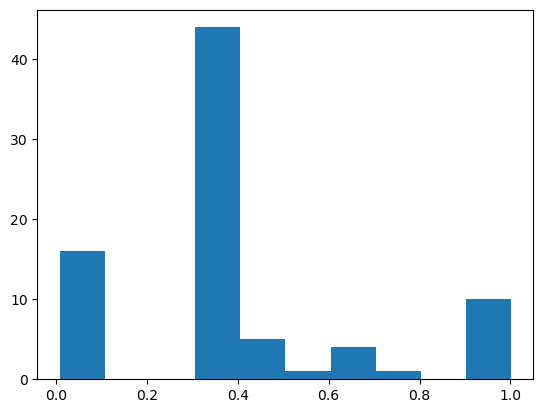

In [22]:
plt.hist(sens1_samps)